In [1]:
# 1

########## 20 February 2019 - Alec S. Hirschauer ##########
# This will be the Python notebook used for identifying
# AGB star candidates in NGC 6822 using a [3.6] vs J-[3.6] CMD
# with data from the Sibbons et al. (2012) WFCAM/UKIRT catalog
# in preparation for the Dusting the Universe conference
# which takes place in March 2019.
#
# Effectively the FOURTH iteration in evolution of this analysis,
# we are attempting to be more considerate of accounting for
# uncertainties in the determination of the color-cut boundaries.
#
# Sundar Srinivasan is currently visiting STScI (22-25 Jan 2019)
# and is helping figure out how to include the photometric
# uncertainties into the KDE analysis.
#
# Future notebooks will be based on this one, but will tackle
# additional CMDs, in no particular order:
# [3.6] vs J-[3.6]
# [8.0] vs [3.6]-[8.0]
# [24] vs [8.0]-[24]
# [8.0] vs J-[8.0]
# [3.6] vs [3.6]-[4.5]
# [8.0] vs [4.5]-[8.0]
#
# ^ Some of the above may be more or less useful than others,
#   but if we can get the whole process automated, then in
#   principle it wouldn't take much more time to do them all.
#
# The various populations include:
# (1) O-rich/M-type AGB star candidates
# (2) C-rich/C-type AGB star candidates
# (3) the first dusty track of O-rich AGB stars
# (4) extremely dusty sources (included with C-types)
#
# ^ Population (4) is likely some C-types + YSOs
#
# Also NB that we will detect plenty of RSG stars at similar colors
# as the AGB stars, but at lower (brighter) magnitudes.
#
# All this will be accomplished by determining first the TRGB,
# which Cioni & Habing (2005) says is at K_s = 17.10 +/- 0.01
# but Sibbons et al. (2012) says is at K_0 = 17.41 +/- 0.11.
#
# I will employ histograms fit with KDE Gaussians to find the
# local minima inflection point over the relevant range of data.
#
# This technique will then also be used to determine the color cuts
# between the various populations as measured by histograms of
# optimum bin width as determined by Knuth's Algorithm.
#
# The Monte Carlo Kernel Density Estimation (MCKDE) method that we
# are developing is unfortunately probably not going to be ready
# by the time I present on 4 March 2019, so I'm going to try to
# make color cuts based on the MCKDE TRGB analysis and then
# my technique of estimating the local minima of inflection points.

In [2]:
# 2

# First thing needed is to import the relevant Python libraries.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.stats import gaussian_kde
# This line is necessary for the number density histograms.
from astropy import stats
from astropy.stats.histogram import knuth_bin_width
# This line is necessary for determining histogram bin width.
from sklearn import neighbors
from scipy.signal import savgol_filter
# These lines are from Sundar's KDE routine

In [3]:
# 3

# Read in my data from a .csv file saved locally.
phot_data = pd.read_csv('CMDKhanANDSibbonsHOME_ahirschauer.csv')
# This is a table of values with 30,745 rows which contains the photometric data of
# the Khan et al. (2015) catalog matched to sources from Sibbons et al. (2012)
# with an "OR" command, then downloaded from MAST CasJobs.
# print phot_data
#
# Also I'll read in the entire Sibbons+ stellar source catalog.
Sibbons_data = pd.read_csv('Sibbons2012NGC6822.csv')
# This is for a test of the histogram(s) I make later on.

In [4]:
# 4

# For the histograms, I have created new .csv files which have the specific colors'
# information: ID, RA, Dec, magnitudes, magnitude errors, color, color error.
#
# I have pre-trimmed the bogus data from these tables already, so there's no need
# to get rid of the whacky 'null' values converted to "-9999" values
# (which, when subtracted from any other value, gives another bogus value)
# like I did in the previous cell with the "full" catalog.
#
jMINUSkDATA = pd.read_csv('jMINUSk.csv')
jMINUSthreesixDATA = pd.read_csv('jMINUSthreesix.csv')
threesixMINUSeightzeroDATA = pd.read_csv('threesixMINUSeightzero.csv')
jMINUSeightzeroDATA = pd.read_csv('jMINUSeightzero.csv')
eightzeroMINUStwentyfourDATA = pd.read_csv('eightzeroMINUStwentyfour.csv')
fourfiveMINUSeightzeroDATA = pd.read_csv('fourfiveMINUSeightzero.csv')
threesixMINUSfourfiveDATA = pd.read_csv('threesixMINUSfourfive.csv')
#
# ^ Note that only the first file is necessary for THIS notebook.

In [5]:
# 5

# The first thing I'll do here is make the J vs J-K CMD & Hess diagram.

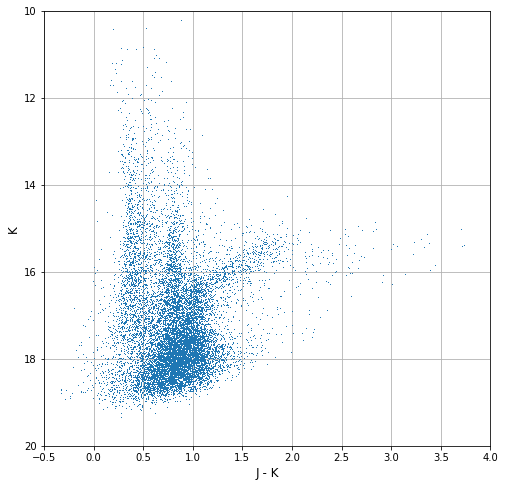

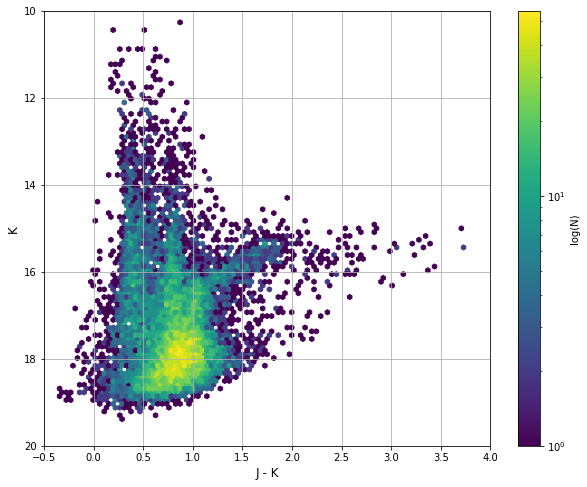

In [6]:
# 6

# K vs J-K
# CMD & Hess diagram
#
plt.figure(figsize=(8,8))
plt.plot(jMINUSkDATA.jMINUSk, jMINUSkDATA.Kmag, ',')
# ^ for presentation plots, change the ',' to a '.'
plt.xlim(-0.5, 4.0)
plt.ylim(20.0, 10.0)
plt.xlabel('J - K', size=12)
plt.ylabel('K', size=12)
plt.grid(True)
plt.show()
plt.close()
#plt.savefig('K_vs_J-K_plot.png')
#
fig, ax1 = plt.subplots(1, 1, figsize=(10, 8))
plt.xlim(-0.5, 4.0)
plt.ylim(20.0, 10.0)
im1 = ax1.hexbin(jMINUSkDATA.jMINUSk, jMINUSkDATA.Kmag, bins='log', cmap=plt.cm.viridis,
               mincnt=1, extent=(-0.5, 4.0, 20.0, 10.0))
ax1.set_xlabel('J - K', size=12)
ax1.set_ylabel('K', size=12)
cb = plt.colorbar(im1, label='log(N)')
plt.grid(True)
plt.show()
plt.close()
#plt.savefig('K_vs_J-K_hist.png')

In [7]:
# 7

# The second thing I'll do is determine where the TRGB should be.
#
# Sibbons et al. (2012) determined it to be at K_0 = 17.41 +/- 0.11,
# and since I'm using their data that seems like a good starting point.
#
# To do so, I'll isolate only the photometric data of sources with
# errors in the magnitudes less than 0.1.

low_error_jMINUSkDATA = jMINUSkDATA[(jMINUSkDATA.eJmag < 0.1) & (jMINUSkDATA.eKmag < 0.1)]

# And as a check, see what the number of sources is for the entire catalog
# versus the number of sources in this trimmed catalog.

print (len(jMINUSkDATA))
print (len(low_error_jMINUSkDATA))

13351
8504


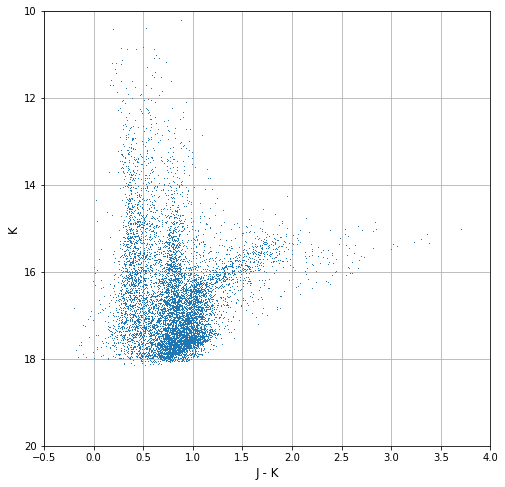

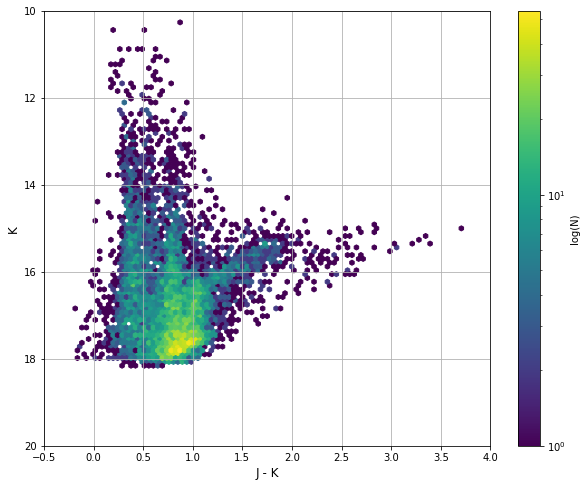

In [8]:
# 8

# With my catalog of only low-error photometry sources, I'll make a
# new CMD and Hess diagram just to see how the data look now.

# K vs J-K (low error)
# CMD & Hess diagram
#
plt.figure(figsize=(8,8))
plt.plot(low_error_jMINUSkDATA.jMINUSk, low_error_jMINUSkDATA.Kmag, ',')
plt.xlim(-0.5, 4.0)
plt.ylim(20.0, 10.0)
#plt.xlim(0.5, 1.5)
#plt.ylim(18.0, 16.0)
plt.xlabel('J - K', size=12)
plt.ylabel('K', size=12)
plt.grid(True)
plt.show()
plt.close()
#plt.savefig('low_error_K_vs_J-K_plot.pdf')
#
fig, ax1 = plt.subplots(1, 1, figsize=(10, 8))
plt.xlim(-0.5, 4.0)
plt.ylim(20.0, 10.0)
#plt.xlim(0.5, 1.5)
#plt.ylim(18.0, 16.0)
im1 = ax1.hexbin(low_error_jMINUSkDATA.jMINUSk, low_error_jMINUSkDATA.Kmag, bins='log', cmap=plt.cm.viridis,
               mincnt=1, extent=(-0.5, 4.0, 20.0, 10.0))
ax1.set_xlabel('J - K', size=12)
ax1.set_ylabel('K', size=12)
cb = plt.colorbar(im1, label='log(N)')
plt.grid(True)
plt.show()
plt.close()
#plt.savefig('low_error_K_vs_J-K_hist.pdf')

In [9]:
# 9

# Definitely looks cleaner than before.
#
# I'll use this trimmed catalog to develop the color cuts themselves,
# but the full catalog when I'm doing the actual source identification.
#
##################################################
#
# At this point, the techniques from my previous methodology are going
# to be modified, in the sense that I'll still be implementing a KDE-style
# Gaussian fit to the resulting histograms and finding the values of the
# local minima, but we'll be including the photometric uncertainties into
# the Gaussians to be more statistically robust.
#
# Furthermore, the position of the TRGB itself will now no longer be
# determined by finding a trough in the histogram (and subsequently finding
# the local minimum's position), but instead a technique more similar to how
# Sibbons et al. (2012) found their TRGB. <- *Sobel Edge Detection Technique*
#
# Instead of finding a trough's minimum, they computed where the slope of the
# Gaussian most steeply falls off, which is indicative of where in color space
# there is a rapid change of stellar population demographics.
#
# It has the net effect of including more stars into the range of our boundaries,
# being more consistent with what TRGB value Sibbons+ came up with (which makes
# sense for K vs J-K since it's all only the same photometric data), and since
# determination of this coordinate is automated (based on the fit's derivative),
# finding the TRGB value in all the other CMDs will be more robust AND faster!
#
# In order to determine the color-cut boundaries, however, I have a concern about
# what coordinate value is decided upon:
#
# If it's the edge (where the derivative is maximum), and we're looking for the
# local minima, could we compute the edges for either side, then take an average?
#
# Also, how do I program a Sobel edge detection?
#
# ^ Sundar wrote something based on previous work done by Peter Scicluna.

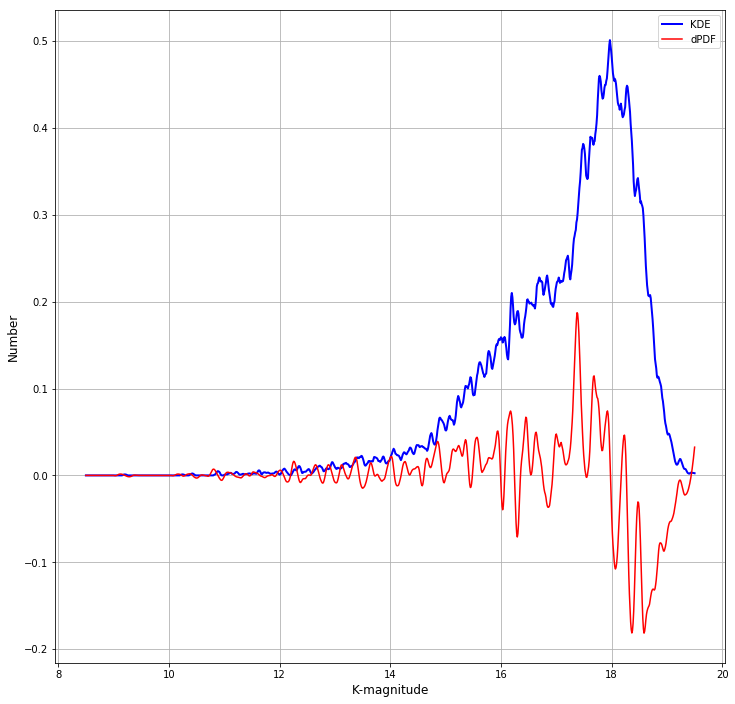

In [10]:
# 10

# This cell shows the non-MC KDE for TRGB determination.
#
# We used this to inform how the multiple realizations of the method
# would work out, even though the MCKDE code looks a bit different.
#
# Once I make the vertical magnitude span bins, I intend to copy
# the code from this cell in order to determine where the breaks
# are in between stellar types, rather than the original KDE
# syntax that was supplied to me by Owen Boberg last year.
#
# If I can't figure out how to get it to work, however, I will fall back
# on the method I used pre-AAS meeting.

def getdata():
    infile = 'jMINUSk.csv'
    #table = np.genfromtxt(infile, delimiter = ',')#, dtype = 'i8, f8, f8, f8, f8, f8, f8, f8, f8')
    table = np.genfromtxt(infile, delimiter = ',', skip_header = 1, dtype = \
                          [('ID', 'i8'), ('RA', 'f8'), ('DEC', 'f8'), ('Jmag', 'f8'), ('eJmag', 'f8'), \
                           ('Kmag', 'f8'), ('eKmag', 'f8'), ('jMINUSk', 'f8'), ('ejMINUSk', 'f8')]) 
    m = table['Kmag']
    dm = table['eKmag']
    return m, dm

def doplot(x, pdfx, dpdfx, data = 0):
    plt.figure(figsize = (12,12))
    plt.plot(x, pdfx, 'k', lw = 2., label = 'KDE', color='blue')
#    if data != 0:
#        plt.hist(data, bins = bins, normed = True, label = 'Binned data')
#    plt.xlim(xlim)
    plt.plot(x, dpdfx*20, 'k', lw = 1.5, label = 'dPDF', color='red')
    plt.legend()
    #plt.axvline(x=17.41, linewidth=1.5, color='lightblue') # Sibbons+ (2012) TRGB value
    #plt.axvline(x=16.955, linewidth=1.5, color='lightgreen') # TRGB value determined from earlier work
    plt.xlabel('K-magnitude', size=12)
    plt.ylabel('Number', size=12)
    plt.grid(True)
    plt.show()
    plt.close()

def main():

    #Read from input table into variables m and dm
    m, dm = getdata()

    #Initialise stuff
    rtol = 1e-5
    kernel = 'epanechnikov' #parabolic kernel
    #mx = np.linspace(min(m)*0.8, max(m)*1.2, 1000)
    mx = np.linspace(8.5, 19.5, 1000)
    #Generate NITER realisations of the KDE

#    for i in range(niter):
    msamp = np.random.normal(m, dm)
    #print(min(msamp))
        #PS: Monte Carlo already smooths the distribution, so reduce the ideal binwidth a bit.
    bandwidth_factor = 0.25
    bandwidth = bandwidth_factor*(np.std(msamp)*(len(msamp)**(-0.2)))
        #Requires you to define the BANDWIDTH and KERNEL variables before this line.
    kde = neighbors.KernelDensity(bandwidth = bandwidth, rtol = rtol, kernel = kernel)
    kde.fit(msamp[:, np.newaxis])
        #MX is the x axis range over which the PDF is computed/plotted.
    pdf = kde.score_samples(mx[:, np.newaxis])
    pdf = np.exp(pdf)
    dpdf = np.gradient(pdf, mx[1] - mx[0]) #mx is equally spaced, provide the spacing as the x difference.
    from scipy.signal import savgol_filter
    pdfsm = savgol_filter(pdf, 3, 2, deriv = 0)
    dpdfsm = savgol_filter(pdf, 31, 3, deriv = 1) 
    # ^ smoothing window should be somehow related to resolution used for x axis
 #       #Plotting
    doplot(mx, pdf, dpdfsm)
    #print(pdf)
    #print(bandwidth)
 #       #Use PDF to do stuff (e.g., detect edges)
 #       #result = do_stuff(pdf)
 #       #Store results of ith iteration
 #       #
 #       #

main()

###TBD:
##1. Plot N visualisations on same plot
##2. Store all PDFs/derivatives and find average of N visualisations and plot that.
##3. Manual cut at K=18 to preserve strongest *positive* derivative.

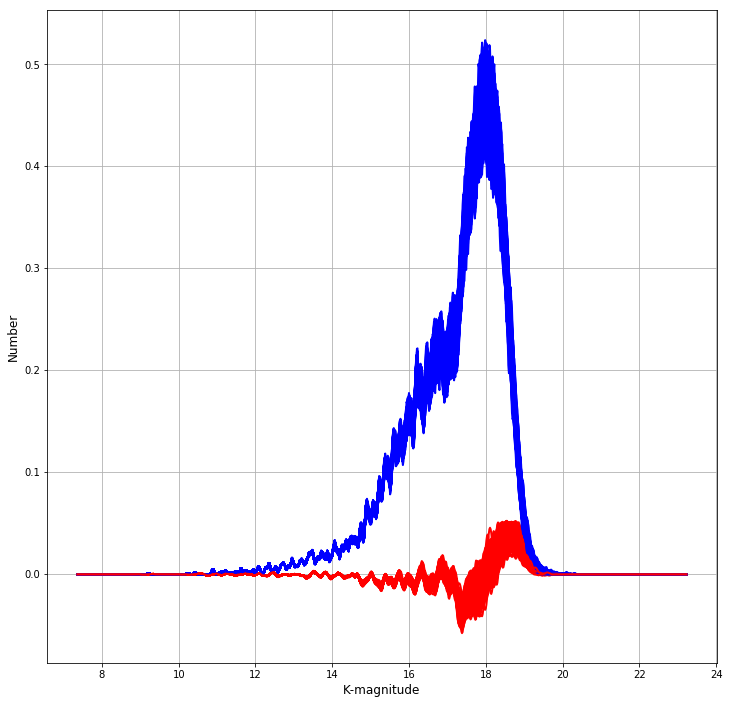

(17.385290080880882, 0.0662234025093878)

In [11]:
# 11

# This cell contains the MCKDE code routine to find the TRGB
# which we are intending on implementing for finding the breaks
# between different stellar types.
#
# Our problem so far has been twofold:
#
# (1) By realizing each time a thousand times, we are giving the
#     analysis a large number of opportunities to explore unlikely
#     paths, and so the resulting unertainties are extremely large.
#
#     Sundar has talked to Peter about this, realizing that what
#     we really should do is find the "natural width" of the
#     distributions, which is an estimate of the standard deviations,
#     which is the 68% spread.
#
# (2) The Savitzky-Golay filter (rather than Sobel filter) is used
#     to determine where the maxima in derivative to the Epanechnikov
#     curve fit to the data is located, which is fine for finding the
#     TRGB, but is less obviously usable for finding the local minima
#     of inflection points.

import numpy as np
import matplotlib.pyplot as plt
from sklearn import neighbors
from scipy.signal import savgol_filter

def getdata(infile = 'jMINUSk.csv', magname = 'Kmag', dmagname = 'eKmag'):
    #table = np.genfromtxt(infile, delimiter = ',')#, dtype = 'i8, f8, f8, f8, f8, f8, f8, f8, f8')
    table = np.genfromtxt(infile, delimiter = ',', skip_header = 1, dtype = \
                          [('ID', 'i8'), ('RA', 'f8'), ('DEC', 'f8'), ('Jmag', 'f8'), ('eJmag', 'f8'), \
                           ('Kmag', 'f8'), ('eKmag', 'f8'), ('jMINUSk', 'f8'), ('ejMINUSk', 'f8')]) 
    m = table[magname]
    dm = table[dmagname]
    return m, dm

def doplot(x, pdfx, deriv = 0, data = 0, first = True, last = False):
    if first: plt.figure(figsize = (12,12))
    plt.plot(x, pdfx, 'k', lw = 2, label = 'KDE', color='blue')
    #if len(data) != 1 and data[0] != 0:
    #    plt.hist(data, bins = bins, normed = True, label = 'Binned data')
    try:
        scale = np.max(pdfx)/np.max(deriv)/10.
        plt.plot(x, deriv*scale, 'r', lw = 2, label = 'dKDE', color='red')
    except:
        print('no derivatives specified')
    if last:
        plt.xlabel('K-magnitude', size=12)
        plt.ylabel('Number', size=12)
        plt.grid(True)
        plt.show()
        plt.close()
    #if len(deriv) != 1 and deriv[0] != 0:
    #    scale = np.max(pdfx)/np.max(deriv)
    #    print(scale)
    #    plt.plot(x, deriv*scale, 'k', lw = 3, label = 'dKDE')
    #    #plt.plot(x, deriv, 'r', lw = 2, label = 'dKDE')

def trgbfind(infile = 'jMINUSk.csv', magname = 'Kmag', dmagname = 'eKmag', niter = 1000, kernel = 'epanechnikov'):

    #Read from input table into variables m and dm
    m, dm = getdata(infile = infile)

    #Initialise stuff
    niter = 1000
    rtol = 1e-5
    kernel = 'epanechnikov' #parabolic kernel
    mx = np.linspace(max(m)*1.2, min(m)*0.8, 1000)
    trgbloc = np.zeros(niter)
    #Generate NITER realisations of the KDE

    for i in range(niter):
        msamp = np.random.normal(m, dm)
        #PS: Monte Carlo already smooths the distribution, so reduce the ideal binwidth a bit.
        bandwidth_factor = 0.25
        bandwidth = bandwidth_factor*(np.std(msamp)*(len(msamp)**(-0.2)))
        #Requires you to define the BANDWIDTH and KERNEL variables before this line.
        kde = neighbors.KernelDensity(bandwidth = bandwidth, rtol = rtol, kernel = kernel)
        kde.fit(msamp[:, np.newaxis])
        #MX is the x axis range over which the PDF is computed/plotted.
        #kde.score_samples returns ln(pdf)
        pdf = np.exp(kde.score_samples(mx[:, np.newaxis]))
        smooth_window = 31
        poly_degree = 3
        dpdf = savgol_filter(pdf, smooth_window, poly_degree, deriv = 1)
        trgbloc[i] = mx[np.argmin(dpdf)] #Most negative value corresponds to highest rate of decrease 
        #Plotting
        doplot(mx, pdf, deriv = dpdf, data = msamp, first = i == 0, last = i == niter - 1)
        #Use PDF to do stuff (e.g., detect edges)
        #result = do_stuff(pdf)
        #Store results of ith iteration
        #
        #

    trgbloc_mean = np.mean(trgbloc)
    trgbloc_sd = np.std(trgbloc)
    return trgbloc_mean, trgbloc_sd
    #print(trgbloc_mean, trgbloc_sd) # this does the same as the above, just differently

trgbfind()


In [12]:
# 12

# NOTE 20 Feb 2019
# The below are notes to myself for continuing analysis,
# so don't worry about them for now.
#
# They deal with how to proceed with progressive bin sizing,
# which may wind up being a moot point (only six bins).

# **************************************************

# KDE and edge-detection stuff aside, I still need to program the
# progressive bin sizes part of the process.
#
# (1) Once the TRGB (with uncertainties) is established, use this
# y-axis value (K-band in the first case) as a starting point.
# 
# (2) Starting at the TRGB value, restrict the catalog of sources
# between the start value to some arbitrary value (say, K = 17.386
# to K = 17.386 + 0.250 = 17.636).
# 
# (3) Print the length of this list.  If it’s longer than a set
# value (say, N = 300?), reduce the range by some small increment
# (say, K = 17.386 to K = 17.386 + 0.249 = 17.635) and print the
# length of the list again.  Repeat until you hit the target threshold.
#
# Sundar's comment on (3): I thought the idea was to have a *minimum* length
# to ensure we don't have too few data points in the bin? Step (3) should start
# with a default bin size, check whether N < 300 and, if so, increase the bin size
# for this bin. Repeat procedure until N >= 300.
#
# [NB: once we get high up on the CMD, even a 0.250 dex span won’t
# encompass our desired number of sources, so maybe this range should
# initially be higher?]
#
# Sundar's comment: Yes, at the very top of the CMD, the bin size will end up being huge.
# This is fine, since we will need a minimum number of points to say something concrete
# about the cut at this level anyway. One possible way to work on this would be as follows:
# 1) At the start of the procedure, initialise a variable that will contain the total number
# of points brighter than the current bin edge. At the beginning of the iterations, this
# variable will contain the total number of sources brighter than the K-band TRGB value. As
# you gradually proceed up the K-band in brightness, the total number of sources brighter
# than this K-band magnitude will decrease. When the number falls below the minimum number
# desired in each bin, then you know the iterations must also cease. This automatically decides
# where the last bin is located, and also how wide it will be.
#
# (4) Once we get a range of y-axis values than encompasses our target
# number of sources, run the KDE routine you wrote out to get the
# Gaussian (or Epanechnikov or whatever) fit to the data.
#
# (5) Run the Sobel edge filter part of the routine to determine the 
# maximum derivative(s) of the fit, which signify the steepest areas
# of the fit, and therefore breaks in the populations.
# In order to determine where the *local minima* are, I suggest
# determining where these are and taking an average of the two locations
# (where the slopes are) and using that to set where the trough of
# a given minimum is.
#
# You had talked about using some high threshold at first to determine
# the *most* maximum derivative, then progressively relaxing this value
# to find other ones.  How might we implement that?
#
# Sundar's comment on #5: While the Sobel filter was used in previous studies, the current
# implementation of our code uses a Savitzky-Golay filter to compute the first derivative. The
# highest-magnitude derivative will be easy to find, but beyond that we will have to be careful.
# I don't know yet what "being careful" entails in this case.
#
# (6) Repeat steps (3) through (5), recording said values somewhere,
# until you reach the end of the CMD’s available sources.
#
# (7) Using these values, representing points along the CMDs, construct
# linear fits to make the color-cut boundaries.
#
# (8) Segregate out the sources within the given boundaries to create
# lists of foreground/MS stars, O-rich AGB star candidates,
# C-rich AGB star candidates, etc., and save those lists.
# 
# (9) Repeat the above steps for the next CMD ([3.6] vs. J – [3.6],
# for example) and compare the resulting lists against one another.


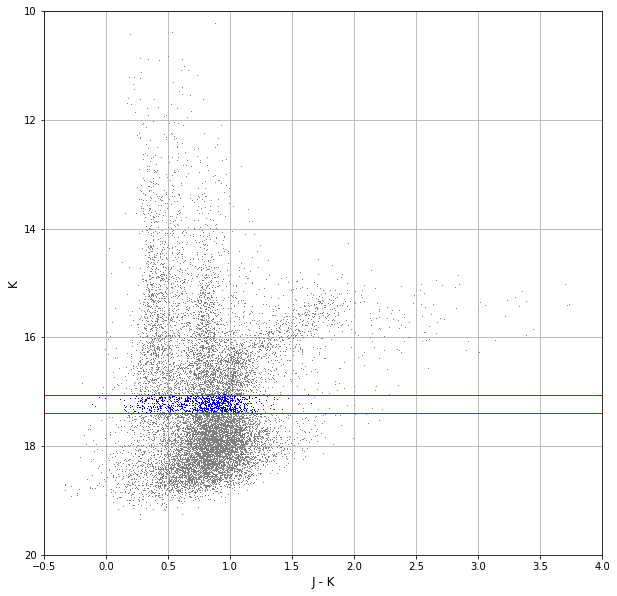

1018
0.06307142857142857
17.386
17.066


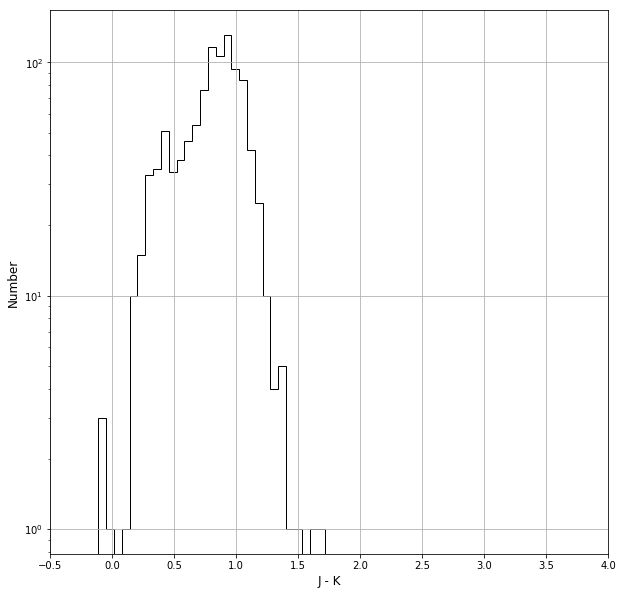

In [13]:
# 13 (Bin 1)

# Here I'm making the CMD of *ONLY* the sources within the first bin above the TRGB.
# Also I'm making a histogram of said sources.

TRGB = 17.386
initial_width = 0.500
width_change = 0.010

jMINUSkHIST = low_error_jMINUSkDATA[(low_error_jMINUSkDATA.Kmag < (TRGB))
                                    & (low_error_jMINUSkDATA.Kmag > (TRGB-initial_width*1.+width_change*18.))]

bin_end = TRGB-initial_width*1.+width_change*18.

plt.figure(figsize=(10,10))
plt.plot(jMINUSkDATA.jMINUSk, jMINUSkDATA.Kmag, ',', color='gray')
plt.plot(jMINUSkHIST.jMINUSk, jMINUSkHIST.Kmag, ',', color='blue')
plt.xlim(-0.5, 4.0)
plt.ylim(20.0, 10.0)
plt.xlabel('J - K', size=12)
plt.ylabel('K', size=12)
#
plt.axhline(y=TRGB, linewidth=1.0, color='red') # Bin 1 - lower boundary
plt.axhline(y=bin_end, linewidth=1.0, color='red') # Bin 1 - upper boundary
#
plt.grid(True)
plt.show()
plt.close()

# define the range of K-band magnitudes over which the bin is sampling
# from the catalog of sources with K-mag and J-mag errors less than 0.1.
#
#print jMINUSkHIST
print(len(jMINUSkHIST))
#
binwidth = stats.knuth_bin_width(jMINUSkHIST.jMINUSk)
bin_number = (max(jMINUSkHIST.jMINUSk)+binwidth)/binwidth
print(binwidth)
#print bin_number
#
print(TRGB)
print(bin_end)
#
fig = plt.figure(figsize = (10,10))
plt.hist(jMINUSkHIST.jMINUSk, bins=np.arange(min(jMINUSkHIST.jMINUSk), max(jMINUSkHIST.jMINUSk) + binwidth, binwidth), histtype='step', color='black')
plt.yscale('log', nonposy='clip')
plt.xlim(-0.5, 4.0)
plt.xlabel('J - K', size=12)
plt.ylabel('Number', size=12)
plt.grid(True)
plt.show()
plt.close()

/Users/ahirschauer/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


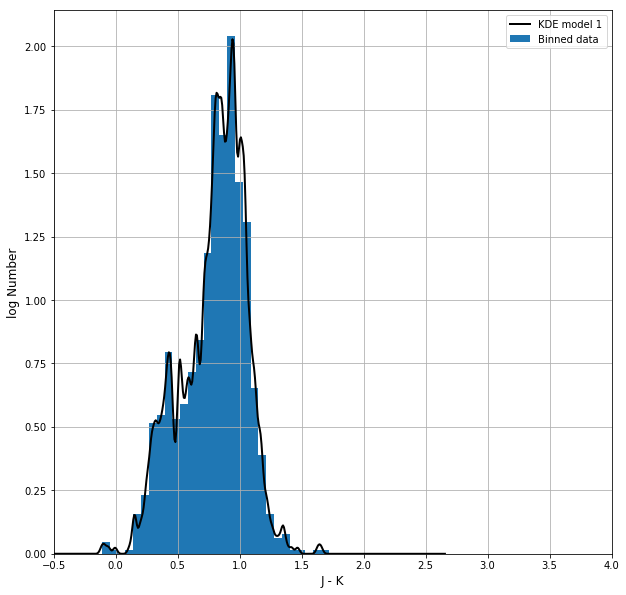

In [14]:
# 14 (Bin 1)

# K = 17.386 to 17.066
#
kde_data = jMINUSkHIST.jMINUSk.values
bins=np.arange(min(kde_data ), max(kde_data ) + binwidth, binwidth)
x_eval = np.linspace(kde_data.min() - 1.0, kde_data.max() + 1.0, 500)
kde = gaussian_kde(kde_data,bw_method=binwidth)
#
plt.figure(figsize=(10,10))
plt.plot(x_eval, kde(x_eval),'k',lw=2,label='KDE model 1')
plt.hist(kde_data,bins=bins,normed=True,label='Binned data')
plt.xlim(-0.5, 4.0)

#plt.xlim(0.47, 0.49)
#plt.ylim(0.43, 0.45)
#plt.xlim(0.87, 0.89)
#plt.ylim(1.62, 1.63)
#plt.xlim(0.98, 0.99)
#plt.ylim(1.56, 1.58)
#plt.xlim(1.29, 1.31)
#plt.ylim(0.06, 0.08)

plt.legend()
plt.xlabel('J - K', size=12)
plt.ylabel('log Number', size=12)
plt.grid(True)
plt.show()
plt.close()
#
### y-intercept: K_0 = 17.226
### boundary 1: J-K = 0.483
### boundary 2: J-K = 0.883
### boundary 3: J-K = 0.988
### boundary 4: J-K = 1.305

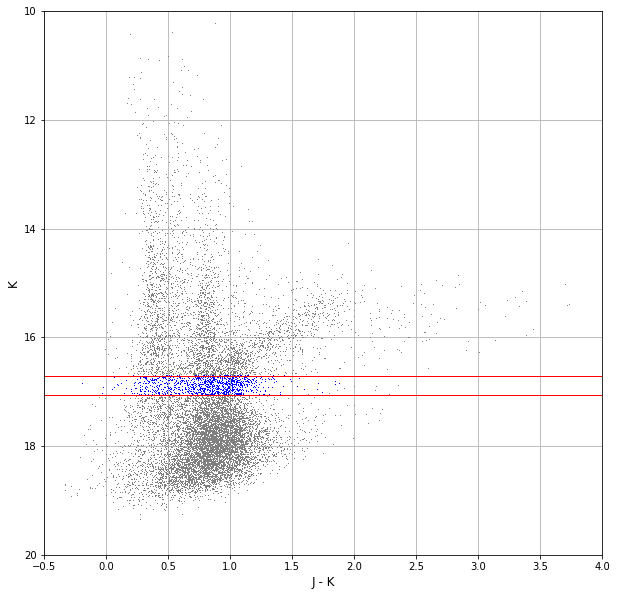

1014
0.07677777777777778
17.066
16.706


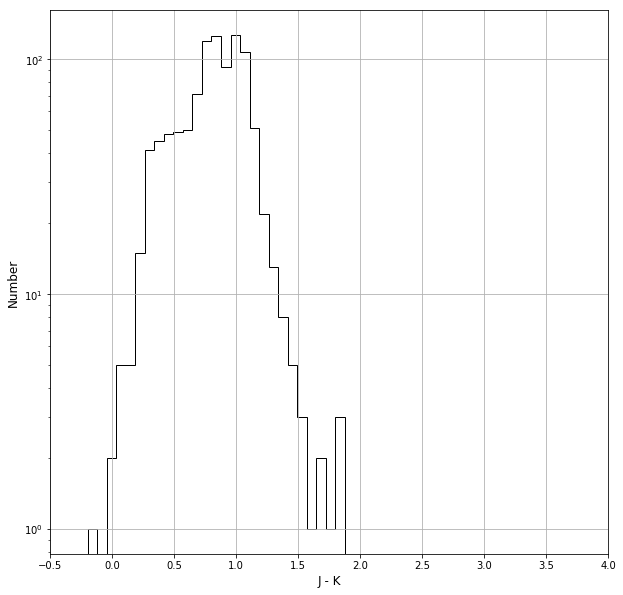

In [15]:
# 15 (Bin 2)

# Here I'm making the CMD of *ONLY* the sources within the second bin above the TRGB.
# Also I'm making a histogram of said sources.

#TRGB = 17.386
#initial_width = 0.500
#width_change = 0.010

TRGB = 17.066

jMINUSkHIST = low_error_jMINUSkDATA[(low_error_jMINUSkDATA.Kmag < (TRGB))
                                    & (low_error_jMINUSkDATA.Kmag > (TRGB-initial_width*1.+width_change*14.))]

bin_end = TRGB-initial_width*1.+width_change*14.

plt.figure(figsize=(10,10))
plt.plot(jMINUSkDATA.jMINUSk, jMINUSkDATA.Kmag, ',', color='gray')
plt.plot(jMINUSkHIST.jMINUSk, jMINUSkHIST.Kmag, ',', color='blue')
plt.xlim(-0.5, 4.0)
plt.ylim(20.0, 10.0)
plt.xlabel('J - K', size=12)
plt.ylabel('K', size=12)
#
plt.axhline(y=TRGB, linewidth=1.0, color='red') # Bin 2 - lower boundary
plt.axhline(y=bin_end, linewidth=1.0, color='red') # Bin 2 - upper boundary
#
plt.grid(True)
plt.show()
plt.close()

# define the range of K-band magnitudes over which the bin is sampling
# from the catalog of sources with K-mag and J-mag errors less than 0.1.
#
#print jMINUSkHIST
print(len(jMINUSkHIST))
#
binwidth = stats.knuth_bin_width(jMINUSkHIST.jMINUSk)
bin_number = (max(jMINUSkHIST.jMINUSk)+binwidth)/binwidth
print(binwidth)
#print bin_number
#
print(TRGB)
print(bin_end)
#
fig = plt.figure(figsize = (10,10))
plt.hist(jMINUSkHIST.jMINUSk, bins=np.arange(min(jMINUSkHIST.jMINUSk), max(jMINUSkHIST.jMINUSk) + binwidth, binwidth), histtype='step', color='black')
plt.yscale('log', nonposy='clip')
plt.xlim(-0.5, 4.0)
plt.xlabel('J - K', size=12)
plt.ylabel('Number', size=12)
plt.grid(True)
plt.show()
plt.close()

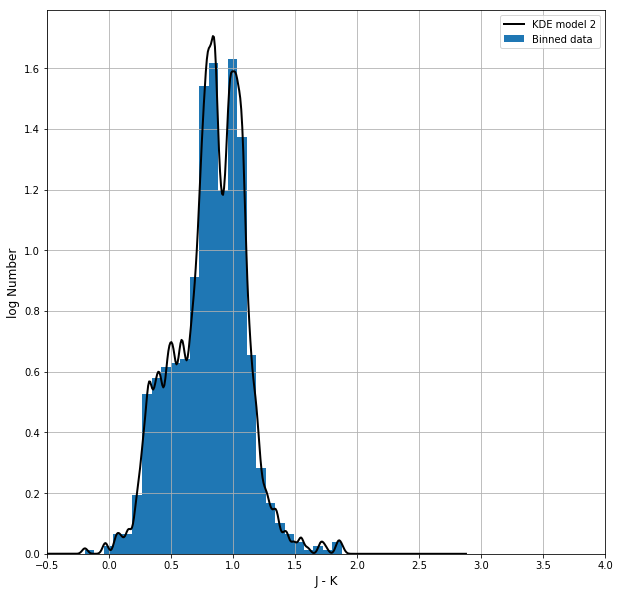

In [16]:
# 16 (Bin 2)

# K = 17.066 to 16.706
#
kde_data = jMINUSkHIST.jMINUSk.values
bins=np.arange(min(kde_data ), max(kde_data ) + binwidth, binwidth)
x_eval = np.linspace(kde_data.min() - 1.0, kde_data.max() + 1.0, 500)
kde = gaussian_kde(kde_data,bw_method=binwidth)
#
plt.figure(figsize=(10,10))
plt.plot(x_eval, kde(x_eval),'k',lw=2,label='KDE model 2')
plt.hist(kde_data,bins=bins,normed=True,label='Binned data')
plt.xlim(-0.5, 4.0)

#plt.xlim(0.53, 0.55)
#plt.ylim(0.62, 0.63)
#plt.xlim(0.91, 0.93)
#plt.ylim(1.18, 1.19)
#plt.xlim(1.0, 1.3)
#plt.ylim(0.1, 1.6)
#plt.xlim(1.50, 1.51)
#plt.ylim(0.035, 0.040)

plt.legend()
plt.xlabel('J - K', size=12)
plt.ylabel('log Number', size=12)
plt.grid(True)
plt.show()
plt.close()
#
### y-intercept: K_0 = 16.886
### boundary 1: J-K = 0.543
### boundary 2: J-K = 0.918
### boundary 3: J-K = 1.084*
### boundary 4: J-K = 1.506

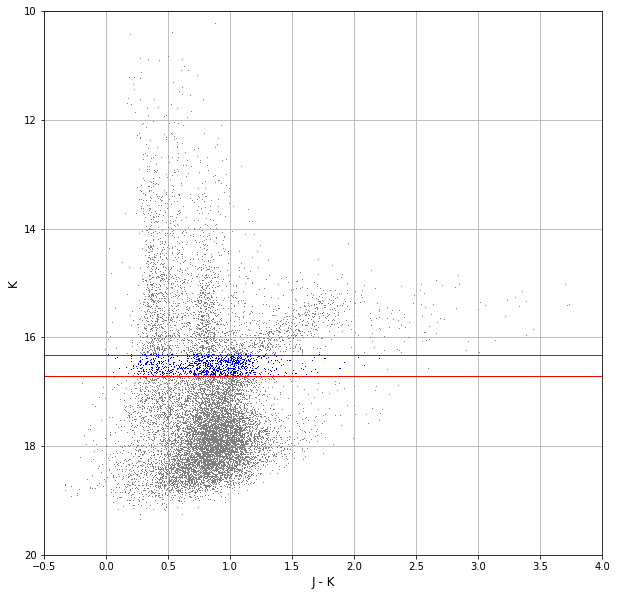

1005
0.07534482758620689
16.706
16.316


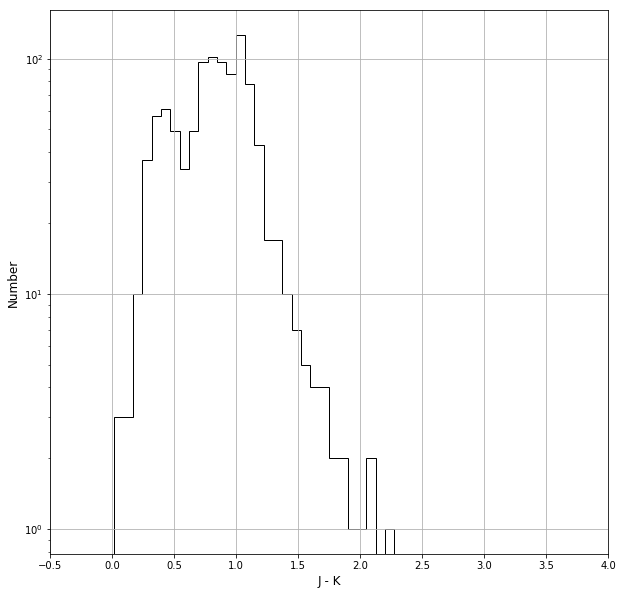

In [17]:
# 17 (Bin 3)

# Here I'm making the CMD of *ONLY* the sources within the third bin above the TRGB.
# Also I'm making a histogram of said sources.

#TRGB = 17.386
#initial_width = 0.500
#width_change = 0.010

TRGB = 16.706

jMINUSkHIST = low_error_jMINUSkDATA[(low_error_jMINUSkDATA.Kmag < (TRGB))
                                    & (low_error_jMINUSkDATA.Kmag > (TRGB-initial_width*1.+width_change*11.))]

bin_end = TRGB-initial_width*1.+width_change*11.

plt.figure(figsize=(10,10))
plt.plot(jMINUSkDATA.jMINUSk, jMINUSkDATA.Kmag, ',', color='gray')
plt.plot(jMINUSkHIST.jMINUSk, jMINUSkHIST.Kmag, ',', color='blue')
plt.xlim(-0.5, 4.0)
plt.ylim(20.0, 10.0)
plt.xlabel('J - K', size=12)
plt.ylabel('K', size=12)
#
plt.axhline(y=TRGB, linewidth=1.0, color='red') # Bin 3 - lower boundary
plt.axhline(y=bin_end, linewidth=1.0, color='red') # Bin 3 - upper boundary
#
plt.grid(True)
plt.show()
plt.close()

# define the range of K-band magnitudes over which the bin is sampling
# from the catalog of sources with K-mag and J-mag errors less than 0.1.
#
#print jMINUSkHIST
print(len(jMINUSkHIST))
#
binwidth = stats.knuth_bin_width(jMINUSkHIST.jMINUSk)
bin_number = (max(jMINUSkHIST.jMINUSk)+binwidth)/binwidth
print(binwidth)
#print bin_number
#
print(TRGB)
print(bin_end)
#
fig = plt.figure(figsize = (10,10))
plt.hist(jMINUSkHIST.jMINUSk, bins=np.arange(min(jMINUSkHIST.jMINUSk), max(jMINUSkHIST.jMINUSk) + binwidth, binwidth), histtype='step', color='black')
plt.yscale('log', nonposy='clip')
plt.xlim(-0.5, 4.0)
plt.xlabel('J - K', size=12)
plt.ylabel('Number', size=12)
plt.grid(True)
plt.show()
plt.close()

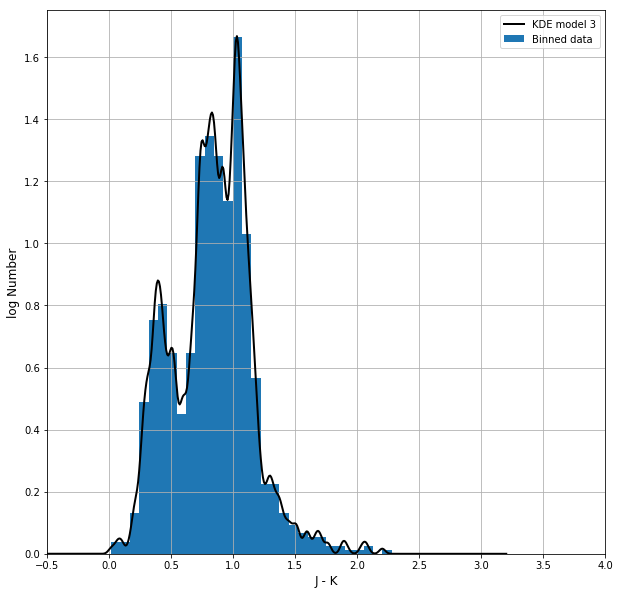

In [18]:
# 18 (Bin 3)

# K = 16.706 to 16.316
#
kde_data = jMINUSkHIST.jMINUSk.values
bins=np.arange(min(kde_data ), max(kde_data ) + binwidth, binwidth)
x_eval = np.linspace(kde_data.min() - 1.0, kde_data.max() + 1.0, 500)
kde = gaussian_kde(kde_data,bw_method=binwidth)
#
plt.figure(figsize=(10,10))
plt.plot(x_eval, kde(x_eval),'k',lw=2,label='KDE model 3')
plt.hist(kde_data,bins=bins,normed=True,label='Binned data')
plt.xlim(-0.5, 4.0)

#plt.xlim(0.568, 0.569)
#plt.ylim(0.481, 0.482)
#plt.xlim(0.95, 0.96)
#plt.ylim(1.13, 1.15)
#plt.xlim(1.25, 1.26)
#plt.ylim(0.22, 0.23)
#plt.xlim(1.82, 1.83)
#plt.ylim(0.0, 0.005)

plt.legend()
plt.xlabel('J - K', size=12)
plt.ylabel('log Number', size=12)
plt.grid(True)
plt.show()
plt.close()
#
### y-intercept: K_0 = 16.511
### boundary 1: J-K = 0.569
### boundary 2: J-K = 0.954
### boundary 3: J-K = 1.256
### boundary 4: J-K = 1.826

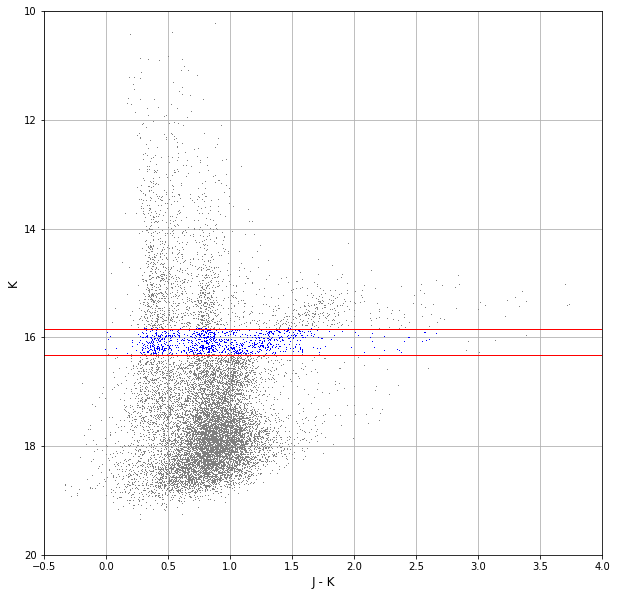

1000
0.11125000000000002
16.316
15.845999999999998


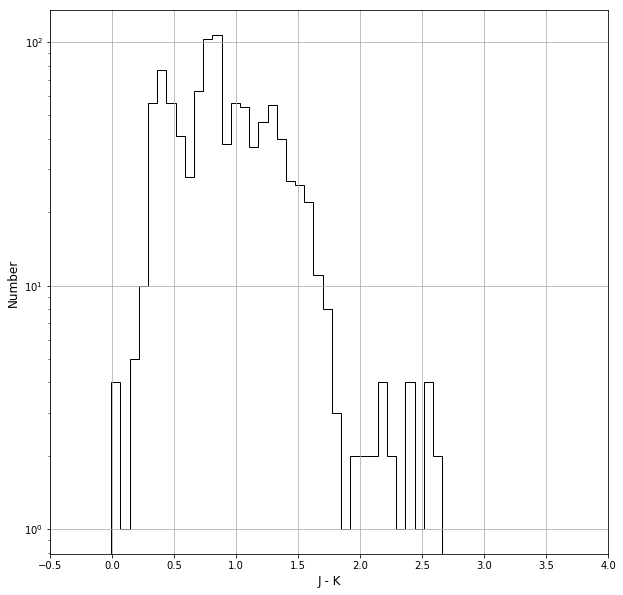

In [19]:
# 19 (Bin 4)

# Here I'm making the CMD of *ONLY* the sources within the fourth bin above the TRGB.
# Also I'm making a histogram of said sources.

#TRGB = 17.386
#initial_width = 0.500
#width_change = 0.010

TRGB = 16.316

jMINUSkHIST = low_error_jMINUSkDATA[(low_error_jMINUSkDATA.Kmag < (TRGB))
                                    & (low_error_jMINUSkDATA.Kmag > (TRGB-initial_width*1.+width_change*3.))]

bin_end = TRGB-initial_width*1.+width_change*3.

plt.figure(figsize=(10,10))
plt.plot(jMINUSkDATA.jMINUSk, jMINUSkDATA.Kmag, ',', color='gray')
plt.plot(jMINUSkHIST.jMINUSk, jMINUSkHIST.Kmag, ',', color='blue')
plt.xlim(-0.5, 4.0)
plt.ylim(20.0, 10.0)
plt.xlabel('J - K', size=12)
plt.ylabel('K', size=12)
#
plt.axhline(y=TRGB, linewidth=1.0, color='red') # Bin 4 - lower boundary
plt.axhline(y=bin_end, linewidth=1.0, color='red') # Bin 4 - upper boundary
#
plt.grid(True)
plt.show()
plt.close()

# define the range of K-band magnitudes over which the bin is sampling
# from the catalog of sources with K-mag and J-mag errors less than 0.1.
#
#print jMINUSkHIST
print(len(jMINUSkHIST))
#
binwidth = stats.knuth_bin_width(jMINUSkHIST.jMINUSk)
bin_number = (max(jMINUSkHIST.jMINUSk)+binwidth)/binwidth
print(binwidth)
#print bin_number
#
print(TRGB)
print(bin_end)
#
fig = plt.figure(figsize = (10,10))
plt.hist(jMINUSkHIST.jMINUSk, bins=np.arange(min(jMINUSkHIST.jMINUSk), max(jMINUSkHIST.jMINUSk) + binwidth/1.5, binwidth/1.5), histtype='step', color='black')
plt.yscale('log', nonposy='clip')
plt.xlim(-0.5, 4.0)
plt.xlabel('J - K', size=12)
plt.ylabel('Number', size=12)
plt.grid(True)
plt.show()
plt.close()

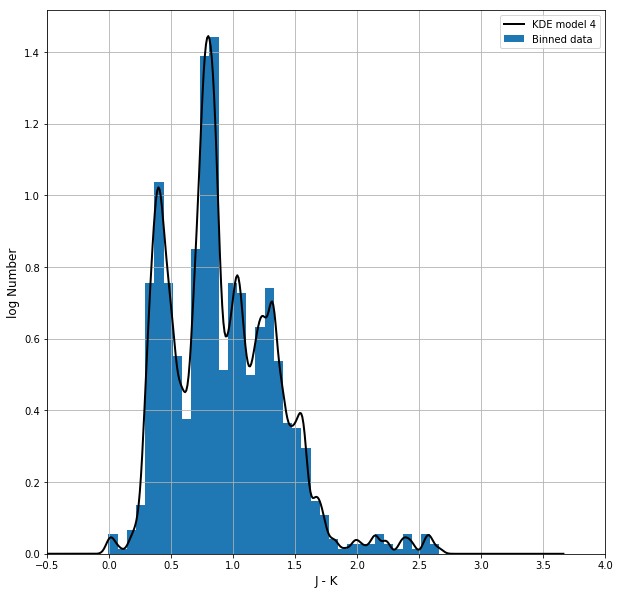

In [20]:
# 20 (Bin 4)

# K = 16.316 to 15.846
#
kde_data = jMINUSkHIST.jMINUSk.values
bins=np.arange(min(kde_data ), max(kde_data ) + binwidth/1.5, binwidth/1.5)
x_eval = np.linspace(kde_data.min() - 1.0, kde_data.max() + 1.0, 500)
kde = gaussian_kde(kde_data,bw_method=binwidth/1.5)
#
plt.figure(figsize=(10,10))
plt.plot(x_eval, kde(x_eval),'k',lw=2,label='KDE model 4')
plt.hist(kde_data,bins=bins,normed=True,label='Binned data')
plt.xlim(-0.5, 4.0)

#plt.xlim(0.61, 0.62)
#plt.ylim(0.44, 0.46)
#plt.xlim(0.938, 0.942)
#plt.ylim(0.606, 0.608)
#plt.xlim(1.13, 1.14)
#plt.ylim(0.52, 0.53)
#plt.xlim(1.89, 1.90)
#plt.ylim(0.015, 0.017)

plt.legend()
plt.xlabel('J - K', size=12)
plt.ylabel('log Number', size=12)
plt.grid(True)
plt.show()
plt.close()
#
### y-intercept: K_0 = 16.081
### boundary 1: J-K = 0.612
### boundary 2: J-K = 0.940
### boundary 3: J-K = 1.136
### boundary 4: J-K = 1.894

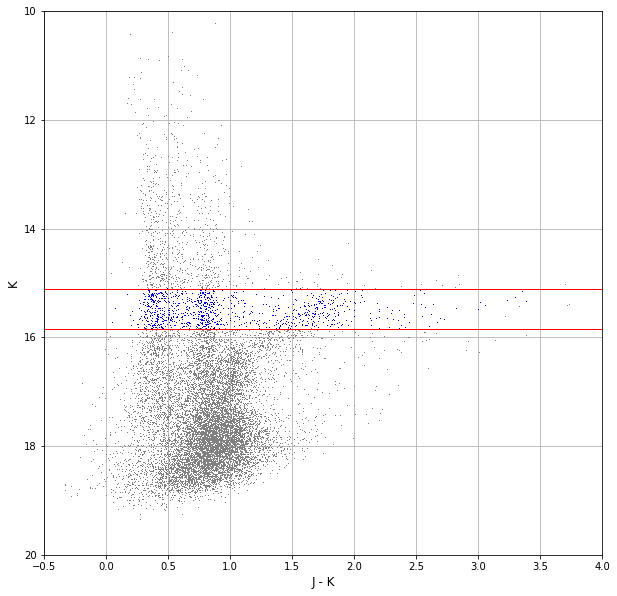

1004
0.1754736842105263
15.846
15.116


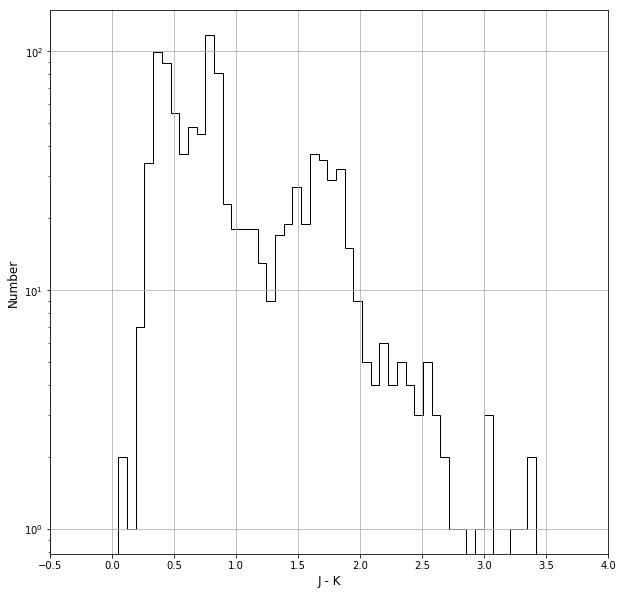

In [21]:
# 21 (Bin 5)

# Here I'm making the CMD of *ONLY* the sources within the fifth bin above the TRGB.
# Also I'm making a histogram of said sources.

#TRGB = 17.386
#initial_width = 0.500
#width_change = 0.010

TRGB = 15.846

jMINUSkHIST = low_error_jMINUSkDATA[(low_error_jMINUSkDATA.Kmag < (TRGB))
                                    & (low_error_jMINUSkDATA.Kmag > (TRGB-initial_width*1.-width_change*23.))]

bin_end = TRGB-initial_width*1.-width_change*23.

plt.figure(figsize=(10,10))
plt.plot(jMINUSkDATA.jMINUSk, jMINUSkDATA.Kmag, ',', color='gray')
plt.plot(jMINUSkHIST.jMINUSk, jMINUSkHIST.Kmag, ',', color='blue')
plt.xlim(-0.5, 4.0)
plt.ylim(20.0, 10.0)
plt.xlabel('J - K', size=12)
plt.ylabel('K', size=12)
#
plt.axhline(y=TRGB, linewidth=1.0, color='red') # Bin 5 - lower boundary
plt.axhline(y=bin_end, linewidth=1.0, color='red') # Bin 5 - upper boundary
#
plt.grid(True)
plt.show()
plt.close()

# define the range of K-band magnitudes over which the bin is sampling
# from the catalog of sources with K-mag and J-mag errors less than 0.1.
#
#print jMINUSkHIST
print(len(jMINUSkHIST))
#
binwidth = stats.knuth_bin_width(jMINUSkHIST.jMINUSk)
bin_number = (max(jMINUSkHIST.jMINUSk)+binwidth)/binwidth
print(binwidth)
#print bin_number
#
print(TRGB)
print(bin_end)
#
fig = plt.figure(figsize = (10,10))
plt.hist(jMINUSkHIST.jMINUSk, bins=np.arange(min(jMINUSkHIST.jMINUSk), max(jMINUSkHIST.jMINUSk) + binwidth/2.5, binwidth/2.5), histtype='step', color='black')
plt.yscale('log', nonposy='clip')
plt.xlim(-0.5, 4.0)
plt.xlabel('J - K', size=12)
plt.ylabel('Number', size=12)
plt.grid(True)
plt.show()
plt.close()

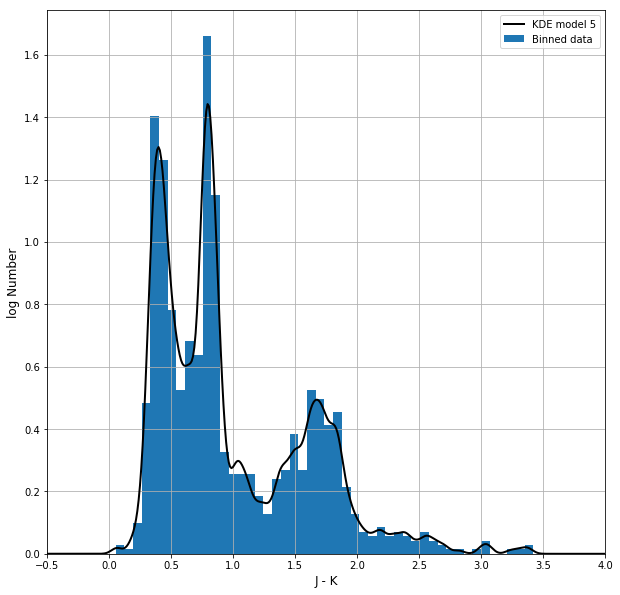

In [22]:
# 22 (Bin 5)

# K = 15.846 to 15.116
#
kde_data = jMINUSkHIST.jMINUSk.values
bins=np.arange(min(kde_data ), max(kde_data ) + binwidth/2.5, binwidth/2.5)
x_eval = np.linspace(kde_data.min() - 1.0, kde_data.max() + 1.0, 500)
kde = gaussian_kde(kde_data,bw_method=binwidth/2.5)
#
plt.figure(figsize=(10,10))
plt.plot(x_eval, kde(x_eval),'k',lw=2,label='KDE model 5')
plt.hist(kde_data,bins=bins,normed=True,label='Binned data')
plt.xlim(-0.5, 4.0)

#plt.xlim(0.61, 0.62)
#plt.ylim(0.602, 0.604)
#plt.xlim(0.98, 0.99)
#plt.ylim(0.26, 0.28)
#plt.xlim(1.26, 1.27)
#plt.ylim(0.162, 0.163)
#plt.xlim(2.905, 2.915)
#plt.ylim(0.002, 0.003)

plt.legend()
plt.xlabel('J - K', size=12)
plt.ylabel('log Number', size=12)
plt.grid(True)
plt.show()
plt.close()
#
### y-intercept: K_0 = 15.481
### boundary 1: J-K = 0.612
### boundary 2: J-K = 0.986
### boundary 3: J-K = 1.264
### boundary 4: J-K = 2.910

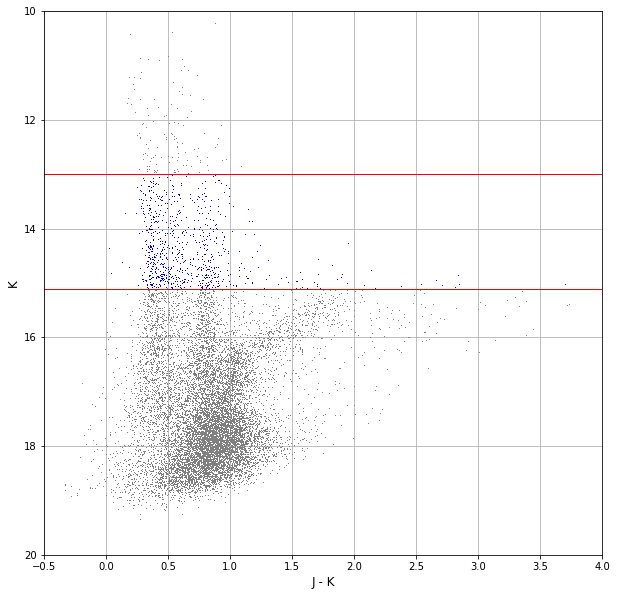

764
0.0782127659574468
15.116
13.0


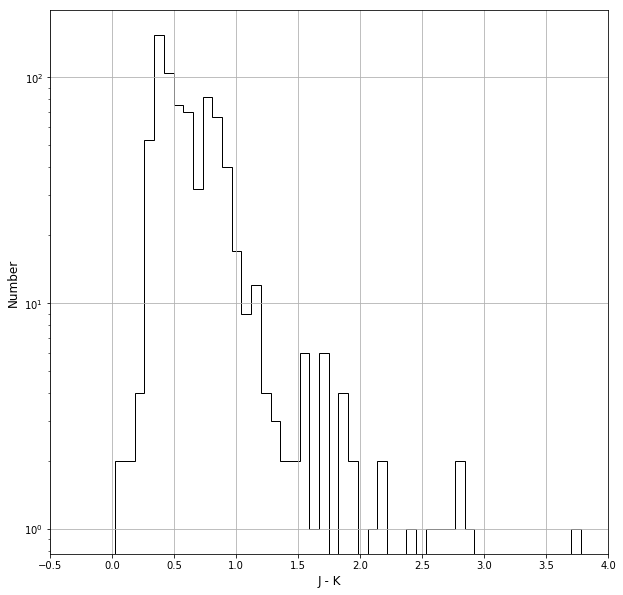

In [23]:
# 23 (Bin 6)

# Here I'm making the CMD of *ONLY* the sources within the sixth bin above the TRGB.
# Also I'm making a histogram of said sources.

#TRGB = 17.386
#initial_width = 0.500
#width_change = 0.010

TRGB = 15.116

jMINUSkHIST = low_error_jMINUSkDATA[(low_error_jMINUSkDATA.Kmag < (TRGB))
                                    & (low_error_jMINUSkDATA.Kmag > 13.)]

bin_end = 13.

plt.figure(figsize=(10,10))
plt.plot(jMINUSkDATA.jMINUSk, jMINUSkDATA.Kmag, ',', color='gray')
plt.plot(jMINUSkHIST.jMINUSk, jMINUSkHIST.Kmag, ',', color='blue')
plt.xlim(-0.5, 4.0)
plt.ylim(20.0, 10.0)
plt.xlabel('J - K', size=12)
plt.ylabel('K', size=12)
#
plt.axhline(y=TRGB, linewidth=1.0, color='red') # Bin 6 - lower boundary
plt.axhline(y=13.0, linewidth=1.0, color='red') # Bin 6 - upper boundary
#
plt.grid(True)
plt.show()
plt.close()

# define the range of K-band magnitudes over which the bin is sampling
# from the catalog of sources with K-mag and J-mag errors less than 0.1.
#
#print jMINUSkHIST
print(len(jMINUSkHIST))
#
binwidth = stats.knuth_bin_width(jMINUSkHIST.jMINUSk)
bin_number = (max(jMINUSkHIST.jMINUSk)+binwidth)/binwidth
print(binwidth)
#print bin_number
#
print(TRGB)
print(bin_end)
#
fig = plt.figure(figsize = (10,10))
plt.hist(jMINUSkHIST.jMINUSk, bins=np.arange(min(jMINUSkHIST.jMINUSk), max(jMINUSkHIST.jMINUSk) + binwidth, binwidth), histtype='step', color='black')
plt.yscale('log', nonposy='clip')
plt.xlim(-0.5, 4.0)
plt.xlabel('J - K', size=12)
plt.ylabel('Number', size=12)
plt.grid(True)
plt.show()
plt.close()

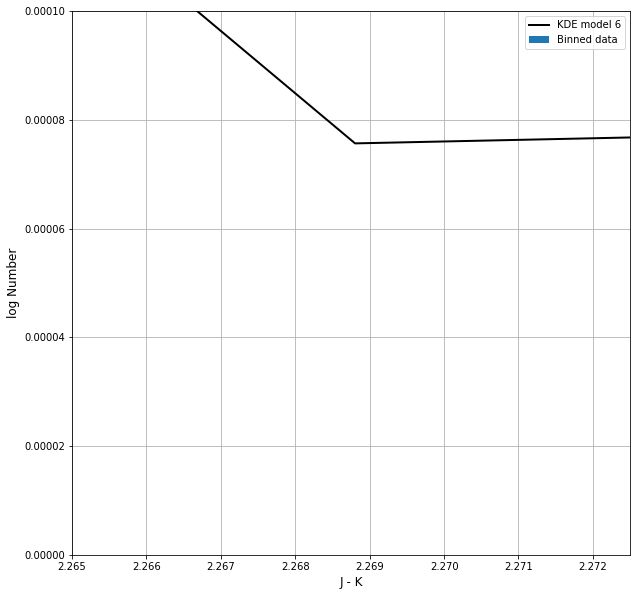

In [56]:
# 24 (Bin 6)

# K = 15.116 to 13.000
#
kde_data = jMINUSkHIST.jMINUSk.values
bins=np.arange(min(kde_data ), max(kde_data ) + binwidth, binwidth)
x_eval = np.linspace(kde_data.min() - 1.0, kde_data.max() + 1.0, 500)
kde = gaussian_kde(kde_data,bw_method=binwidth)
#
plt.figure(figsize=(10,10))
plt.plot(x_eval, kde(x_eval),'k',lw=2,label='KDE model 6')
plt.hist(kde_data,bins=bins,normed=True,label='Binned data')
plt.xlim(-0.5, 4.0)

#plt.xlim(0.685, 0.69)
#plt.ylim(0.61, 0.63)
#plt.xlim(1.07, 1.08)
#plt.ylim(0.148, 0.155)
#plt.xlim(1.3575, 1.36)
#plt.ylim(0.0250, 0.0275)
#plt.xlim(1.785, 1.795)
#plt.ylim(0.01, 0.02)
#plt.xlim(2.0175, 2.020)
#plt.ylim(0.004, 0.006)
#plt.xlim(2.265, 2.2725)
#plt.ylim(0.0, 0.0001)

plt.legend()
plt.xlabel('J - K', size=12)
plt.ylabel('log Number', size=12)
plt.grid(True)
plt.show()
plt.close()
#
### y-intercept: K_0 = 14.058
### boundary 1: J-K = 0.688
### boundary 2: J-K = 1.075
### boundary 3: J-K = 1.359 -> 1.791 -> 2.019 -> 2.269
### boundary 4: J-K = 

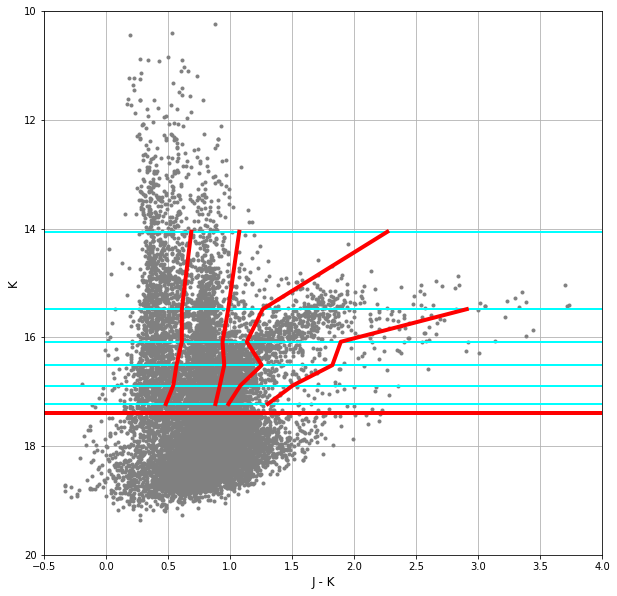

In [59]:
# 25

# K vs J-K
# CMD with color-points and lines
#
plt.figure(figsize=(10, 10))
plt.plot(jMINUSkDATA.jMINUSk, jMINUSkDATA.Kmag, '.', color='gray')
plt.xlim(-0.5, 4.0)
plt.ylim(20.0, 10.0)
plt.xlabel('J - K', size=12)
plt.ylabel('K', size=12)
#
### where are the magnitude span bin midpoints?
#
plt.axhline(y=17.226, linewidth=2.0, color='cyan')
plt.axhline(y=16.886, linewidth=2.0, color='cyan')
plt.axhline(y=16.511, linewidth=2.0, color='cyan')
plt.axhline(y=16.081, linewidth=2.0, color='cyan')
plt.axhline(y=15.481, linewidth=2.0, color='cyan')
plt.axhline(y=14.058, linewidth=2.0, color='cyan')
#
### plot points
#
yvalues1 = np.array([17.226, 16.886, 16.511, 16.081, 15.481, 14.058])
yvalues2 = np.array([17.226, 16.886, 16.511, 16.081, 15.481, 14.058])
yvalues3 = np.array([17.226, 16.886, 16.511, 16.081, 15.481, 14.058])
yvalues4 = np.array([17.226, 16.886, 16.511, 16.081, 15.481])
boundary1 = np.array([0.483, 0.543, 0.569, 0.612, 0.612, 0.688])
boundary2 = np.array([0.883, 0.918, 0.954, 0.940, 0.986, 1.075])
boundary3 = np.array([0.988, 1.084, 1.256, 1.136, 1.264, 2.269])
boundary4 = np.array([1.305, 1.506, 1.826, 1.894, 2.910])
#
plt.plot(boundary1, yvalues1, linewidth=4.0, color='red')
plt.plot(boundary2, yvalues2, linewidth=4.0, color='red')
plt.plot(boundary3, yvalues3, linewidth=4.0, color='red')
plt.plot(boundary4, yvalues4, linewidth=4.0, color='red')
#
plt.axhline(y=17.386, linewidth=4.0, color='red') # TRGB threshold
extremely_dusty = 2.094 # from previous analysis
#

plt.grid(True)
plt.show()
plt.close()